# Business questions:
A small-sized IT firm is seeking to prepare a list of desirable qualities for the programers it seeks to employ.
A junior datascientist at the firm was tasked to look at the 2017 StackOverflow survey and try to identify factors which can help the firm in identifying potential recruits. 

The junior data scientist prepared the following business questions.

1) Based on the survey result, what do programmers care most about?
2) What is the role of pay and job security in programmers satisfaction with their current job?
3) Overall, what explanatory variable relate to job satisfaction?

### How does parents' education related to success in the IT field

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv')

/home/fk/anaconda3/envs/myEnv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Below, we select only respondant who reported having actively coded before the survey

In [2]:
#remove columns with null values for the 'YearsCodedJob' column
pr = df[~df['YearsCodedJob'].isna()]

In [3]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema[schema['Column'] == column_name]['Question'])[0]
    return desc

The distribution of coding experience is tilted towards earlier years, with more than 40 percent of respondants
having less than 5 years of experience in coding.

In [4]:
pr['YearsCodedJob'].value_counts()/pr.shape[0]

1 to 2 years        0.129347
2 to 3 years        0.116581
3 to 4 years        0.097897
4 to 5 years        0.083272
20 or more years    0.075006
Less than a year    0.074199
5 to 6 years        0.073123
9 to 10 years       0.047836
6 to 7 years        0.046760
10 to 11 years      0.041037
7 to 8 years        0.040059
8 to 9 years        0.031475
15 to 16 years      0.020665
14 to 15 years      0.020543
11 to 12 years      0.020494
12 to 13 years      0.018122
16 to 17 years      0.016972
17 to 18 years      0.013328
13 to 14 years      0.012986
19 to 20 years      0.010443
18 to 19 years      0.009856
Name: YearsCodedJob, dtype: float64

This next part tries to assess what programers care most about? 
On relevant field is response to the WorkPayCare question 

In [5]:
get_description('WorkPayCare')

"I don't really care what I work on, so long as I'm paid well"

In [6]:
#summary response to the 'WorkPayCare' question 
work_pay = pr['WorkPayCare'].value_counts()/pr.shape[0]
work_pay

Disagree             0.280876
Strongly disagree    0.156004
Somewhat agree       0.124407
Agree                0.045023
Strongly agree       0.015260
Name: WorkPayCare, dtype: float64

42 percent of respondents do not consider pay/salary the most important factor in their decision of what job to do

Interestingly, those who care more about what type of job they do, on avarage earn a higher salary

In [7]:
pr.groupby(['WorkPayCare']).mean(numeric_only=True)['Salary'].sort_values().dropna()

WorkPayCare
Strongly agree       51249.450459
Agree                53731.692491
Strongly disagree    55829.330933
Disagree             57558.868263
Somewhat agree       57611.563635
Name: Salary, dtype: float64

In addition, those who care most about what type of job they do are shown to favor some level of remote work 

In [8]:
pd.DataFrame(pr.query("WorkPayCare == 'Strongly disagree' or WorkPayCare == 'Disagree'").groupby(['HomeRemote']).mean(numeric_only=True)['JobSatisfaction']).sort_values(by='JobSatisfaction')

,JobSatisfaction
HomeRemote,
Never,6.763353
It's complicated,6.844697
"More than half, but not all, the time",7.000000
About half the time,7.135135
A few days each month,7.149242
"Less than half the time, but at least one day each week",7.155397
All or almost all the time (I'm full-time remote),7.487844


A look at both Job Satisfaction and Career Satisfaction seems to exhibit a right skewed distribution, with most
respondents expressing happiness with their current job and career path. The sentiment about career path is in 
particular interesting since more than 40 percent of respondents have less than 5 years of coding experience

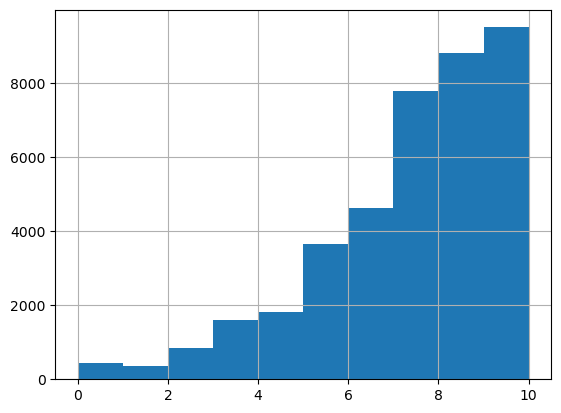

In [9]:
pr['JobSatisfaction'].hist();

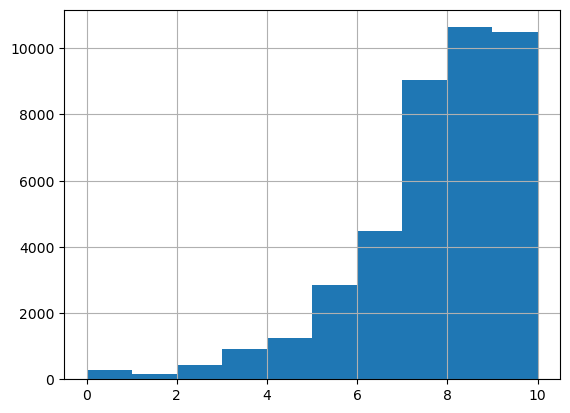

In [10]:
pr['CareerSatisfaction'].hist();

In [11]:
#The following question on job security was posed to respondents
get_description('JobSecurity')

'Job security is important to me'

In [12]:
#55 percent agree on the importance of job security
pr['JobSecurity'].value_counts()/pr.shape[0]

Agree                0.262411
Somewhat agree       0.157178
Strongly agree       0.145757
Disagree             0.050012
Strongly disagree    0.011470
Name: JobSecurity, dtype: float64

Overall, it appears, respondents care more about landing a desirable and secure job 

#### Does job/career satisfaciton relate with other variables in a cause and effect

#### What determines career satisfaction among respondents?

Below, we select 'JobSatisfaction' as the dependent variable and prepare to use a regression to assess the explanatory power of other responses. We start by cleaning the data.

In [13]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['JobSatisfaction'], axis=0)
    y = df['JobSatisfaction']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'ExpectedSalary', 'JobSatisfaction'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df) 

Since missing values affect the outcome of the regression, we want to use various scenarios of missing value levels in the regression. The following function yields the optimal output for selected cuttoff points of missing value levels. 

In [14]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

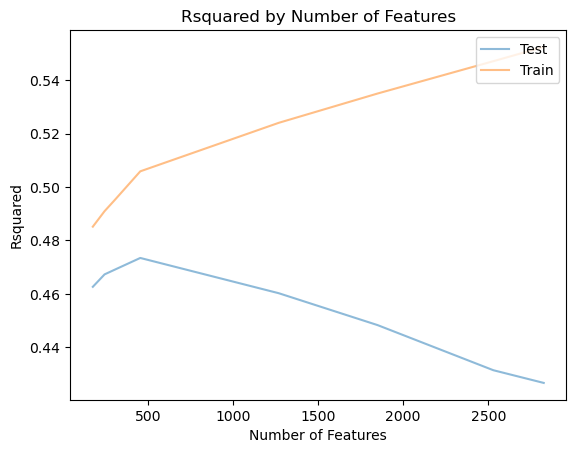

In [15]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

The model records a maximum r-squared of 54 percent for about 2500 explanatory variables. This shows job satisfaction is not explained by the other responses provided.
The divergence in the r-squared result for the train and test data further reveals the weakness of the model.

In [16]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

454
0.47342301105184503
0.5058496071010484


In [18]:
# retrieve model coefficients
model_coef = lm_model.named_steps['linearregression'].coef_

helper function to extract the coefficient of the model

In [19]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = model_coef
    coefs_df['abs_coefs'] = np.abs(model_coef)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


In [20]:
#Use the function
coef_df = coef_weights(model_coef, X_train)

In [21]:
#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
0,CareerSatisfaction,1.254240,1.254240
140,JobSeekingStatus_I am not interested in new jo...,0.356633,0.356633
141,"JobSeekingStatus_I'm not actively looking, but...",0.319008,0.319008
396,StackOverflowJobSearch_Haven't done at all,0.230255,0.230255
236,Overpaid_Greatly underpaid,-0.142783,0.142783
144,LastNewJob_More than 4 years ago,-0.131846,0.131846
142,LastNewJob_Between 2 and 4 years ago,-0.105415,0.105415
334,EquipmentSatisfiedRW_Very satisfied,0.079906,0.079906
338,InfluenceInternet_Very satisfied,0.079262,0.079262
324,EquipmentSatisfiedRAM_Satisfied,-0.073663,0.073663


While the overall explanatory power of the model is poor, we can see from the top 20 coefficients that some variable show strong relationship with job satisfaction.Not surprisingly, those express higher career satisfaction are likely to have higher satisfaction at their current job. It is also reasonable to hear people expressing disinterest in new jobs when they already have higher job satisfaction.

A small-sized firm trying to locate talent would find the above finding challenging.

People who feel underpaid in their current job expressing job dissatisfaction is understandable.

#### Next, we fit logistic regression to the data since

Job satifaction is effectively a categorical variable since the range for the values is from 1-10 only.
Below, we modify the function used to find an optimal set of coefficients to specify the logistic regression algorithm as the model

In [22]:
def find_optimal_lo_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lo_model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
        lo_model.fit(X_train, y_train)
        y_test_preds = lo_model.predict(X_test)
        y_train_preds = lo_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lo_model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
    lo_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lo_model, X_train, X_test, y_train, y_test

Next, we run the model, with similar scenarios of for selecting missing value levels

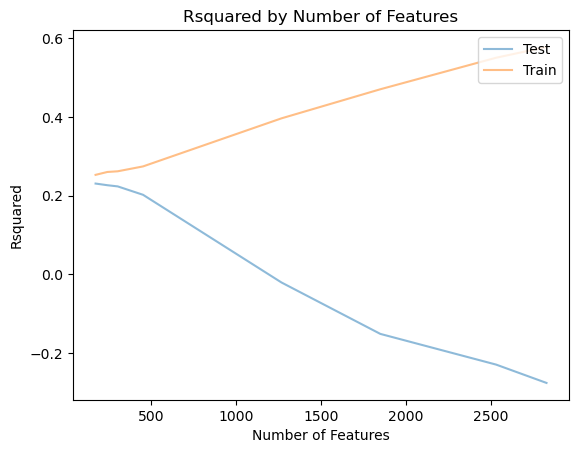

In [23]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test_l, r2_scores_train_l, lo_model, X_train_l, X_test_l, y_train_l, y_test_l = find_optimal_lo_mod(X, y, cutoffs)

The overall result is weaker than the linear regression model. It appears, the model tends to show a slight improvement on the training data. But its capacity to predict based on unseen data is worse than the linear regression model.

In [24]:
print(X_train_l.shape[1]) #Number of columns
print(r2_scores_test_l[np.argmax(r2_scores_test_l)]) # The model we should implement test_r2
print(r2_scores_train_l[np.argmax(r2_scores_test_l)]) # The model we should implement train_r2

175
0.23040938291984858
0.25253750343898895


In [25]:
lo_coef = lo_model.named_steps['logisticregression'].coef_

In [26]:
def coef_weights_lo(coefficients, X_train_l):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train_l.columns
    coefs_df['coefs'] = lo_coef
    coefs_df['abs_coefs'] = np.abs(lo_coef)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df